<a href="https://colab.research.google.com/github/conwayjw97/Image-Colourisation/blob/master/src/CAECifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Conv2D, Flatten, Lambda, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import cifar10, mnist
from tensorflow.keras.callbacks import ReduceLROnPlateau

# !pip install talos
import talos as ta

In [0]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
train_images = train_images / 255.0
test_images = test_images / 255.0

class_train_indices = np.argwhere(train_labels == 0)
class_train_images = train_images[class_train_indices[:,0]]
class_test_indices = np.argwhere(test_labels == 0)
class_test_images = test_images[class_test_indices[:,0]]

train_yuvImages = tf.image.rgb_to_yuv(class_train_images)
train_y = tf.expand_dims(train_yuvImages[:,:,:,0], 3)
train_uv = train_yuvImages[:,:,:,1:]

test_yuvImages = tf.image.rgb_to_yuv(class_test_images)
test_y = tf.expand_dims(test_yuvImages[:,:,:,0], 3)
test_uv = test_yuvImages[:,:,:,1:]

In [52]:
# https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder_deconv.py

parameters = {
    'batch_size': [128, 256, 512],
    'latent_dim': [128, 256, 512],
    'lr': [0.001, 0.0001, 0.00001],
    'momentum': [0.0, 0.25, 0.5]
}

batch_size = 32
kernel_size = 3
latent_dim = 256
epochs = 100

# Define Encoder
inputs = Input(shape=(train_y.shape[1], train_y.shape[2], train_y.shape[3]))
layer = inputs
layer = Conv2D(filters=8, kernel_size=kernel_size, activation='relu', strides=2, padding='same')(layer)
layer = Conv2D(filters=16, kernel_size=kernel_size, activation='relu', strides=2, padding='same')(layer)
layer = Conv2D(filters=32, kernel_size=kernel_size, activation='relu', strides=2, padding='same')(layer)
layer = Conv2D(filters=64, kernel_size=kernel_size, activation='relu', strides=2, padding='same')(layer)
shape = K.int_shape(layer) # Shape before flattening

# Latent space
layer = Flatten()(layer)
latent = Dense(latent_dim)(layer)

# Instantiate Encoder
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

# Define Decoder
latent_inputs = Input(shape=(latent_dim,))
layer = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
layer = Reshape((shape[1], shape[2], shape[3]))(layer)
layer = Conv2DTranspose(filters=64, kernel_size=kernel_size, activation='relu', strides=2, padding='same')(layer)
layer = Conv2DTranspose(filters=32, kernel_size=kernel_size, activation='relu', strides=2, padding='same')(layer)
layer = Conv2DTranspose(filters=16, kernel_size=kernel_size, activation='relu', strides=2, padding='same')(layer)
layer = Conv2DTranspose(filters=8, kernel_size=kernel_size, activation='relu', strides=2, padding='same')(layer)
outputs = Conv2DTranspose(filters=2, kernel_size=kernel_size, activation='sigmoid', padding='same')(layer)

# Instantiate Decoder
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# Autoencoder
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

# Reduce learning rate by sqrt(0.1) if the loss does not improve in 5 epochs
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               verbose=1,
                               min_lr=0.5e-6)

# Define loss
opt = RMSprop(lr=0.0001, momentum=0.0)
# autoencoder.compile(loss='mse', optimizer='adam')
autoencoder.compile(loss='mse', optimizer=opt)

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 16, 16, 8)         80        
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 8, 8, 16)          1168      
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 4, 4, 32)          4640      
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 2, 2, 64)          18496     
_________________________________________________________________
flatten_12 (Flatten)         (None, 256)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 256)               6579

In [0]:
# scan_results = ta.Scan(train_y, train_uv, parameters, autoencoder, "Autoencoder optimisation")

In [54]:
# Train
autoencoder.fit(train_y, train_uv, validation_data=(test_y, test_uv), epochs=epochs, batch_size=batch_size, callbacks=[])

Train on 5000 samples, validate on 1000 samples
Epoch 1/100
5000/5000 [==============================] - 2s 471us/sample - loss: 0.1007 - val_loss: 0.0051
Epoch 2/100
5000/5000 [==============================] - 1s 231us/sample - loss: 0.0048 - val_loss: 0.0048
Epoch 3/100
5000/5000 [==============================] - 1s 226us/sample - loss: 0.0048 - val_loss: 0.0048
Epoch 4/100
5000/5000 [==============================] - 1s 223us/sample - loss: 0.0048 - val_loss: 0.0048
Epoch 5/100
5000/5000 [==============================] - 1s 230us/sample - loss: 0.0048 - val_loss: 0.0048
Epoch 6/100
5000/5000 [==============================] - 1s 234us/sample - loss: 0.0048 - val_loss: 0.0048
Epoch 7/100
5000/5000 [==============================] - 1s 221us/sample - loss: 0.0048 - val_loss: 0.0048
Epoch 8/100
5000/5000 [==============================] - 1s 219us/sample - loss: 0.0048 - val_loss: 0.0047
Epoch 9/100
5000/5000 [==============================] - 1s 216us/sample - loss: 0.0047 - val_lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


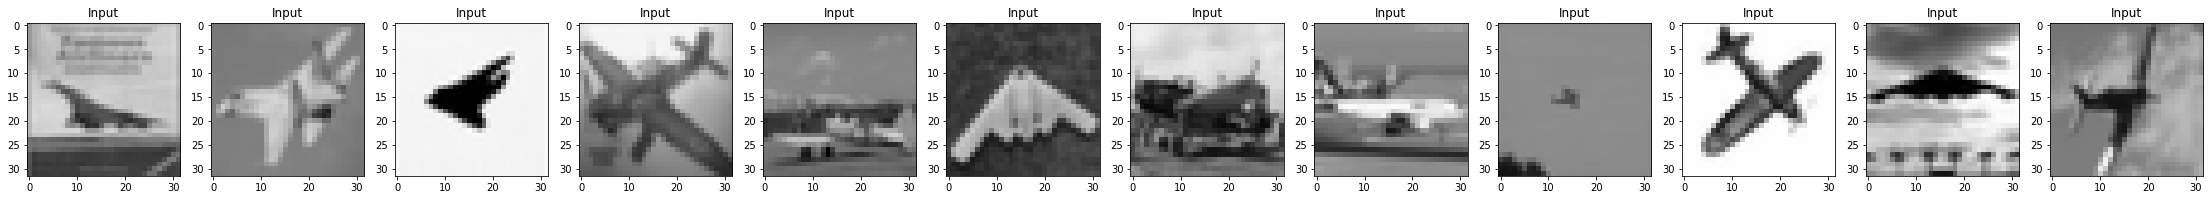

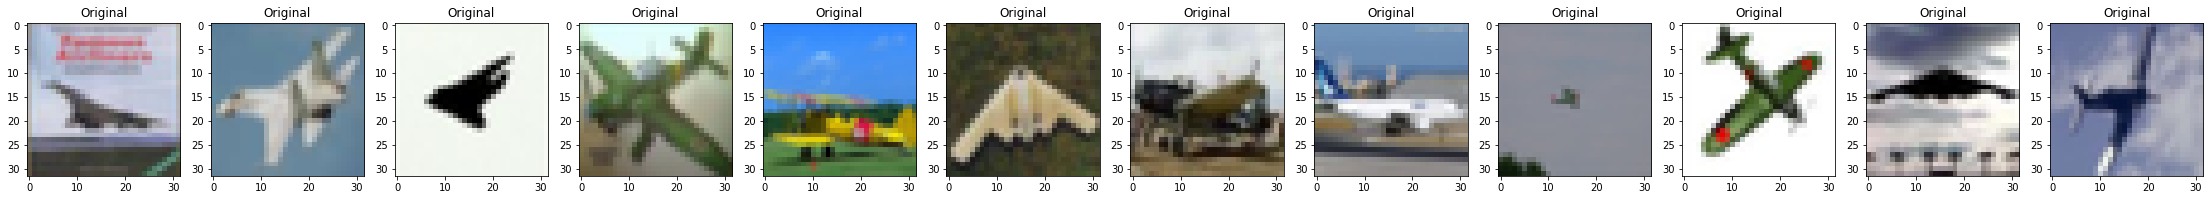

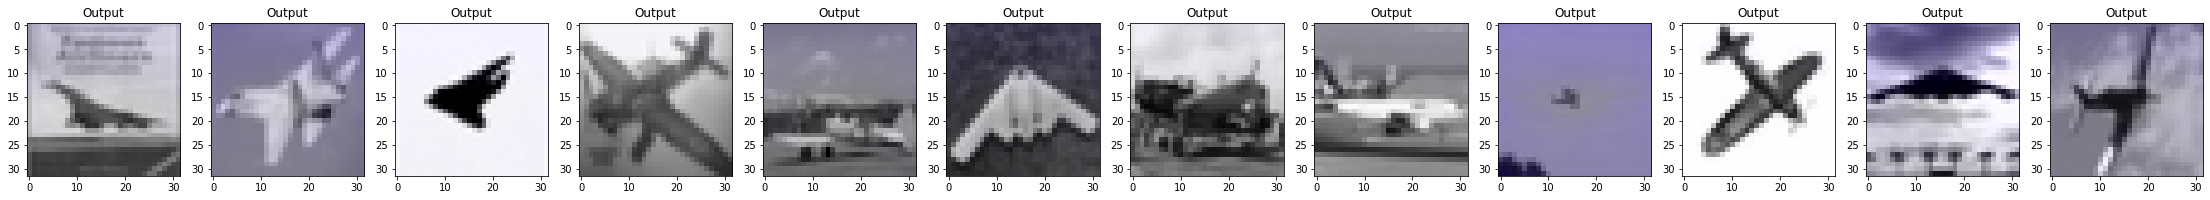

In [55]:
output = autoencoder.predict(test_y)
result = np.zeros((test_yuvImages.shape[0], 32, 32, 3))
result[:,:,:,0] = test_y[:,:,:,0]
result[:,:,:,1:] = output

output_count = 12

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Input")
  plt.imshow(tf.image.grayscale_to_rgb(test_y[i]))

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Original")
  plt.imshow(class_test_images[i])

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Output")
  plt.imshow(tf.image.yuv_to_rgb(result[i]))